# Use AutoAI and model refinement capabilities to predict credit risk with `ibm-watsonx-ai`

This notebook contains the steps and code to demonstrate support of AI Lifecycle features of am AutoAI model in Watson Machine Learning Service in Watson Machine Learning service. It contains steps and code to work with [ibm-watsonx-ai](https://pypi.python.org/pypi/ibm-watsonx-ai) library available in PyPI repository. It also introduces commands for  training, persisting and deploying model, scoring it, updating the model and redeploying it.

Some familiarity with Python is helpful. This notebook uses Python 3.10.


## Learning goals

The learning goals of this notebook are:

-  Work with Watson Machine Learning experiments to train AutoAI models.
-  Persist an external model in Watson Machine Learning repository.
-  Deploy model for online scoring using client library.
-  Score sample records using client library.
-  Update previously persisted model.
-  Redeploy model in-place.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Optimizer definition](#definition)
3.	[Experiment Run](#run)
4.	[Persist and Deploy trained AutoAI model](#persistence)
5.	[Refine and persist new version of the model](#refine)
6.  [Redeploy and score new version of the model](#redeploy)
7.  [Clean up](#cleanup)
8.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/watson-machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>).
-  Create a <a href="https://console.bluemix.net/catalog/infrastructure/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage can be found <a href="https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**


### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide Cloud `API key` and `location`.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.


You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve the instance `location`.

```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```


**NOTE:** You can also get a service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, and then copy the created key and paste it in the following cell.


**Action**: Enter your `api_key` and `location` in the following cell.

In [1]:
api_key = 'PUT_YOUR_KEY_HERE'
location = 'us-south'

In [1]:
credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install -U autoai-libs | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install -U 'snapml>=1.13.0,<1.14.0' | tail -n 1
!pip install -U 'lale[fairness]>=0.7,<0.8' | tail -n 1

In [3]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

You need to create a space that will be used for your work. If you do not have a space, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=wx) to create one.

- Click **New Deployment Space**
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press **Create**
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: assign space ID below

In [4]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use the `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set the **space** which you will be using.

In [5]:
client.set.default_space(space_id)

'SUCCESS'

### Connections to COS

In next cell we read the COS credentials from the space.

In [6]:
cos_credentials = client.spaces.get_details(space_id=space_id)['entity']['storage']['properties']

<a id="definition"></a>
## 2. Optimizer definition

### Training data connection

Define connection information to COS bucket and training data CSV file. This example uses the [German Credit Risk dataset](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/data/credit_risk/credit_risk_training_light.csv).

The code in next cell uploads training data to the bucket.

In [8]:
filename = 'credit_risk_training_light.csv'
datasource_name = 'bluemixcloudobjectstorage'
bucketname = cos_credentials['bucket_name']

Download training data from git repository.

In [9]:
import os, wget

url = 'https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/data/credit_risk/credit_risk_training_light.csv'
if not os.path.isfile(filename): wget.download(url)

#### Create connection

In [10]:
conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Connection to Database - {datasource_name} ",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: client.connections.get_datasource_type_uid_by_name(datasource_name),
    client.connections.ConfigurationMetaNames.DESCRIPTION: "Connection to external Database",
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': bucketname,
        'access_key': cos_credentials['credentials']['editor']['access_key_id'],
        'secret_key': cos_credentials['credentials']['editor']['secret_access_key'],
        'iam_url': 'https://iam.cloud.ibm.com/identity/token',
        'url': cos_credentials['endpoint_url']
    }
}

conn_details = client.connections.create(meta_props=conn_meta_props)

Creating connections...
SUCCESS


**Note**: The above connection can be initialized alternatively with `api_key` and `resource_instance_id`.  
The above cell can be replaced with:


```
conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Connection to Database - {db_name} ",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: client.connections.get_datasource_type_uid_by_name(db_name),
    client.connections.ConfigurationMetaNames.DESCRIPTION: "Connection to external Database",
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': bucket_name,
        'api_key': cos_credentials['apikey'],
        'resource_instance_id': cos_credentials['resource_instance_id'],
        'iam_url': 'https://iam.cloud.ibm.com/identity/token',
        'url': 'https://s3.us.cloud-object-storage.appdomain.cloud'
    }
}

conn_details = client.connections.create(meta_props=conn_meta_props)

```

In [11]:
connection_id = client.connections.get_uid(conn_details)

Define connection information to training data.

In [17]:
from ibm_watsonx_ai.helpers import DataConnection, S3Location


credit_risk_conn = DataConnection(
    connection_asset_id=connection_id,
    location=S3Location(bucket=bucketname,
                        path=filename))

training_data_reference=[credit_risk_conn]

Check the connection information. Upload the data and validate.

In [18]:
credit_risk_conn._wml_client = client
credit_risk_conn.write(data=filename, remote_name=filename)
credit_risk_conn.read()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0_to_200,22,credits_paid_to_date,repairs,812,less_100,4_to_7,3,male,none,...,savings_insurance,19,bank,rent,1,unemployed,1,none,yes,No Risk
245,0_to_200,13,prior_payments_delayed,furniture,2735,500_to_1000,4_to_7,2,female,none,...,savings_insurance,45,stores,rent,2,skilled,1,none,yes,Risk
246,less_0,28,credits_paid_to_date,radio_tv,530,less_100,1_to_4,2,male,none,...,real_estate,32,stores,own,1,skilled,1,none,yes,No Risk
247,less_0,17,credits_paid_to_date,retraining,2119,less_100,1_to_4,3,female,none,...,savings_insurance,23,bank,rent,1,unskilled,1,none,yes,No Risk


### Optimizer configuration

Provide the input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric

In [19]:
from ibm_watsonx_ai.experiment import AutoAI

experiment = AutoAI(credentials, space_id=space_id)

pipeline_optimizer = experiment.optimizer(
    name='Credit Risk Prediction - AutoAI',
    prediction_type=AutoAI.PredictionType.BINARY,
    prediction_column='Risk',
    scoring=AutoAI.Metrics.ROC_AUC_SCORE,
)

Configuration parameters can be retrieved via `get_params()`.

In [20]:
pipeline_optimizer.get_params()

{'name': 'Credit Risk Prediction - AutoAI',
 'desc': '',
 'prediction_type': 'binary',
 'prediction_column': 'Risk',
 'prediction_columns': None,
 'timestamp_column_name': None,
 'scoring': 'roc_auc',
 'holdout_size': None,
 'max_num_daub_ensembles': None,
 't_shirt_size': 'l',
 'train_sample_rows_test_size': None,
 'include_only_estimators': None,
 'include_batched_ensemble_estimators': None,
 'backtest_num': None,
 'lookback_window': None,
 'forecast_window': None,
 'backtest_gap_length': None,
 'cognito_transform_names': None,
 'csv_separator': ',',
 'excel_sheet': None,
 'encoding': 'utf-8',
 'positive_label': None,
 'drop_duplicates': True,
 'outliers_columns': None,
 'text_processing': None,
 'word2vec_feature_number': None,
 'daub_give_priority_to_runtime': None,
 'text_columns_names': None,
 'sampling_type': None,
 'sample_size_limit': None,
 'sample_rows_limit': None,
 'sample_percentage_limit': None,
 'number_of_batch_rows': None,
 'n_parallel_data_connections': None,
 'test_

<a id="run"></a>
## 3. Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [21]:
run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

Training job 81990bbc-6f9d-4101-bde6-985189c84071 completed: 100%|████████| [04:03<00:00,  2.43s/it]


You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

In [22]:
pipeline_optimizer.get_run_status()

'completed'

#### Load trained model

In [23]:
pipeline = pipeline_optimizer.get_pipeline()

#### Reading training data from COS

In [24]:
train_df = pipeline_optimizer.get_data_connections()[0].read()

train_X = train_df.drop(['Risk'], axis=1).values
train_y = train_df.Risk.values

<a id="persistence"></a>
## 4. Persist and Deploy trained AutoAI model

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

### Online deployment creation

In [25]:
from ibm_watsonx_ai.deployment import WebService

service = WebService(credentials, source_space_id=space_id)

service.create(
    experiment_run_id=run_details["metadata"]["id"],
    model="Pipeline_1", 
    deployment_name="AutoAI credit-risk deployment")

Preparing an AutoAI Deployment...
Published model uid: 6eb0393b-5175-4ea7-b60e-51696e64dfbf
Deploying model 6eb0393b-5175-4ea7-b60e-51696e64dfbf using V4 client.


#######################################################################################

Synchronous deployment creation for uid: '6eb0393b-5175-4ea7-b60e-51696e64dfbf' started

#######################################################################################


initializing
Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='a7356206-c33a-4425-9ed9-a33fdd1f7d46'
------------------------------------------------------------------------------------------------




Deployment object could be printed to show basic information:

In [ ]:
print(service)

To show all available information about the deployment use the `.get_params()` method:

In [ ]:
service.get_params()

### Scoring of webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [28]:
predictions = service.score(payload=train_df.drop(['Risk'], axis=1).iloc[:10])
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['No Risk', [1.0, 0.0]],
    ['No Risk', [1.0, 0.0]],
    ['No Risk', [1.0, 0.0]],
    ['No Risk', [1.0, 0.0]],
    ['Risk', [0.1, 0.9]],
    ['Risk', [0.0, 1.0]],
    ['No Risk', [1.0, 0.0]],
    ['No Risk', [1.0, 0.0]],
    ['No Risk', [0.9226527570789866, 0.07734724292101341]],
    ['Risk', [0.0, 1.0]]]}]}

If you want to work with the web service in an external Python application you can retrieve the service object by:
 - Initialize the service by `service = WebService(wml_credentials)`
 - Get deployment_id by `service.list()` method
 - Get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

### Deleting deployment
You can delete the existing deployment by calling the `service.delete()` command.
To list the existing web services you can use `service.list()`.

<a id="refine"></a>
## 5. Refine and persist new version of the model

In this section, you'll learn how to store new refinement version of your model in Watson Machine Learning repository by using the Watson Machine Learning Client.

### Pipeline refinement with [Lale](https://github.com/IBM/lale)

In this section you learn how to refine and retrain the best
pipeline returned by AutoAI. There are many ways to refine a pipeline.
For illustration, simply replace the final estimator in the
pipeline by an interpretable model. The call to
`wrap_imported_operators()` augments scikit-learn operators with
schemas for hyperparameter tuning.

In [29]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from lale.lib.lale import Hyperopt
from lale import wrap_imported_operators

wrap_imported_operators()

#### Pipeline decomposition and new definition

Start by removing the last step of the pipeline, i.e., the final estimator.

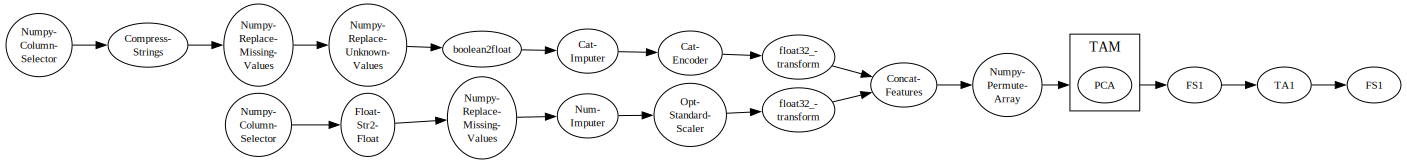

In [30]:
prefix = pipeline.remove_last().freeze_trainable()
prefix.visualize()

Next, add a new final step, which consists of a choice of three
estimators. In this code, `|` is the or combinator (algorithmic
choice). It defines a search space for another optimizer run.

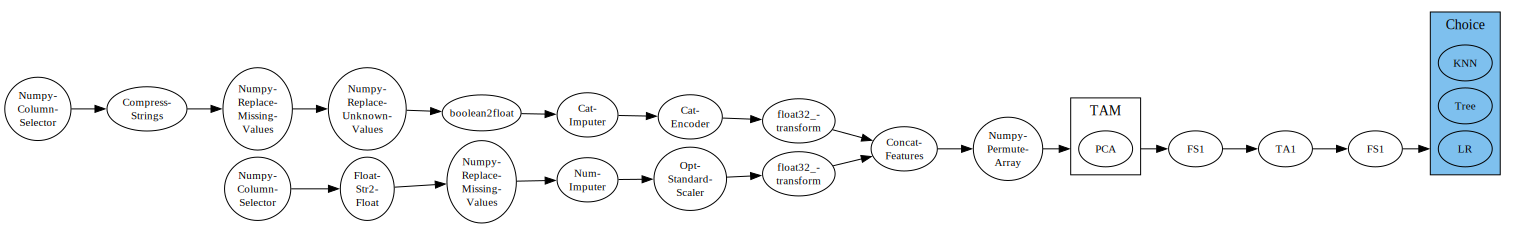

In [31]:
new_pipeline = prefix >> (LR | Tree | KNN)
new_pipeline.visualize()

#### New optimizer `Hyperopt` configuration and training

To automatically select the algorithm and tune its hyperparameters, we
create an instance of the `Hyperopt` optimizer and `fit` it to the
data.

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.15, random_state=33)

In [ ]:
hyperopt = Hyperopt(estimator=new_pipeline, cv=3, max_evals=20, scoring='roc_auc')
hyperopt_pipelines = hyperopt.fit(X_train, y_train)

In [34]:
pipeline_model = hyperopt_pipelines.get_pipeline(astype='sklearn')

#### Save newly refined pipeline

In [ ]:
import joblib

model_path = "refined_pipeline.pickle"
joblib.dump(pipeline_model, model_path)

In [37]:
import tarfile

with tarfile.open(model_path + ".tar.gz", "w:gz") as tar:
    tar.add(model_path)
model_path += ".tar.gz"

### Publish new version of the model

#### Download current version of the model

In [38]:
model_id = service.get_params()['entity']['asset']['id']
deployment_id = service.get_params()['metadata']['id']

Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.
Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.


In [ ]:
downloaded_model_name = "current_model.zip"
client.repository.download(model_id, downloaded_model_name)

In [40]:
import zipfile

with zipfile.ZipFile(downloaded_model_name, "r") as zip_ref:
    zip_ref.extractall()

#### Create archive containing updated model

In [41]:
updated_model_path = "updated_model.zip"
with zipfile.ZipFile(updated_model_path, "w") as zip_ref:
    zip_ref.write(model_path)
    zip_ref.write("pipeline-model.json")

#### Save the current model version

In [ ]:
import json

print(json.dumps(client.repository.create_model_revision(model_id), indent=2))

#### Update the model

In [43]:
metadata = {
    client.repository.ModelMetaNames.NAME: 'AutoAI credit-risk updated model'
}

published_model = client.repository.update_model(
    model_uid=model_id,
    update_model=updated_model_path,
    updated_meta_props=metadata
)

#### Save new model revision of the updated model

In [ ]:
new_model_revision = client.repository.create_model_revision(model_id)
print(json.dumps(new_model_revision, indent=2))

**Note:** Model revisions can be identified by model `id` and `rev` number. 

Get model `rev` number from creation details:

In [45]:
rev_id = new_model_revision['metadata'].get('rev')

#### List list existing revisions of the model

In [46]:
client.repository.list_models_revisions(model_id)

--  --------------------------------  ------------------------
ID  NAME                              CREATED
2   AutoAI credit-risk updated model  2024-03-07T10:02:23.516Z
1   P1                                2024-03-07T10:02:23.516Z
--  --------------------------------  ------------------------


,ID,NAME,CREATED
0,2,AutoAI credit-risk updated model,2024-03-07T10:02:23.516Z
1,1,P1,2024-03-07T10:02:23.516Z


#### Get details of updated model

In [ ]:
print(json.dumps(client.repository.get_details(model_id), indent=2))

<a id="redeploy"></a>
## 6. Redeploy and score new version of the model

In this section, you'll learn how to redeploy new version of the model by using the Watson Machine Learning Client.

In [48]:
metadata = {
    client.deployments.ConfigurationMetaNames.ASSET: {
        "id": model_id,
        "rev": rev_id
    }
}
    
updated_deployment = client.deployments.update(deployment_id, changes=metadata)

Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.
Since ASSET is patched, deployment with new asset id/rev is being started. Monitor the status using deployments.get_details(deployment_uid) api


Wait for the deployment update: 

In [49]:
import time

status = None
while status not in ['ready', 'failed']:
    print('.', end=' ')
    time.sleep(2)
    deployment_details = client.deployments.get_details(deployment_id)
    status = deployment_details['entity']['status'].get('state')
    
print("\nDeployment update finished with status: ", status)

. Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.

Deployment update finished with status:  ready


#### Get updated deployment details

In [ ]:
print(json.dumps(client.deployments.get_details(deployment_id), indent=2))

### Score updated model

In [51]:
scoring_payload = {"input_data": [{"values": train_df.drop(['Risk'], axis=1).iloc[:5]}]}

Use client.deployments.score() method to run scoring.

In [52]:
predictions = client.deployments.score(deployment_id, scoring_payload)

In [53]:
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "fields": [
        "prediction",
        "probability"
      ],
      "values": [
        [
          "No Risk",
          [
            1.0,
            0.0
          ]
        ],
        [
          "No Risk",
          [
            1.0,
            0.0
          ]
        ],
        [
          "No Risk",
          [
            1.0,
            0.0
          ]
        ],
        [
          "No Risk",
          [
            1.0,
            0.0
          ]
        ],
        [
          "Risk",
          [
            0.1,
            0.9
          ]
        ]
      ]
    }
  ]
}


<a id="cleanup"></a>
## 7. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 8. Summary and next steps

 You successfully completed this notebook! You learned how to use scikit-learn machine learning as well as Watson Machine Learning for model creation and deployment. Check out our _[Online Documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html?context=wx)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Jan Sołtysik**, Intern 

**Mateusz Szewczyk**, Software Engineer at Watson Machine Learning.

Copyright © 2020-2024 IBM. This notebook and its source code are released under the terms of the MIT License.